In [1]:
import pandas as pd
import numpy as np

import time
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

#settings
start_time = time.time()
color = sns.color_palette()
sns.set_style('dark')
eng_stopwords = set(stopwords.words('english'))
warnings.filterwarnings('ignore')

lem = WordNetLemmatizer()
tokenizer = TweetTokenizer()

%matplotlib inline

Using TensorFlow backend.


In [2]:
#importing the dataset
train=pd.read_csv("../input/train.csv")
test=pd.read_csv("../input/test.csv")

In [3]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values

In [4]:
merge = pd.concat([train.iloc[:,0:2], test.iloc[:,0:2]])
df = merge.reset_index(drop=True)

In [5]:
corpus=merge.comment_text

In [6]:
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [7]:
def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    #Convert to lower case , so that Hi and hi are the same
    comment = comment.lower()
    #remove \n
    comment = re.sub("\\n"," ",comment)
    # remove leaky elements like ip,user
    comment = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #removing usernames
    comment = re.sub("\[\[.*\]","",comment)
    
    #Split the sentences into words
    words = tokenizer.tokenize(comment)
    
    # (')aphostophe replacement (ie)   you're --> you are  
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    words = [APPO[word] if word in APPO else word for word in words]
    words = [lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    
    clean_sent = " ".join(words)
    # remove any non alphanum,digit character
    #clean_sent=re.sub("\W+"," ",clean_sent)
    #clean_sent=re.sub("  "," ",clean_sent)
    return(clean_sent)

In [8]:
clean_corpus=corpus.apply(lambda x :clean(x))

In [9]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(clean_corpus))
list_tokenized_train = tokenizer.texts_to_sequences(clean_corpus[:159571])
list_tokenized_test = tokenizer.texts_to_sequences(clean_corpus[159571:])

In [10]:
maxlen = 130
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [11]:
trainTotalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

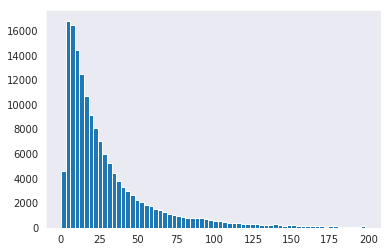

In [12]:
plt.hist(trainTotalNumWords,bins = np.arange(0,200,3))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

In [13]:
inp = Input(shape=(maxlen, ))

In [14]:
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

In [15]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

In [16]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [17]:
batch_size = 32
epochs = 2
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 919s 6ms/step - loss: 0.0704 - acc: 0.9772 - val_loss: 0.0504 - val_acc: 0.9816
Epoch 2/2
 46496/143613 [========>.....................] - ETA: 9:56 - loss: 0.0450 - acc: 0.9829

In [18]:
result = model.predict(X_te)

In [19]:
result = pd.DataFrame(result)

In [20]:
result['id'] = test['id']

In [21]:
result.columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate", 'id']

In [22]:
result.set_index('id')

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,0.997823,1.837181e-01,0.971145,2.802511e-02,0.914378,0.112376
0000247867823ef7,0.000957,5.406277e-07,0.000024,5.219289e-06,0.000064,0.000013
00013b17ad220c46,0.012177,1.116533e-05,0.000353,9.719657e-05,0.000850,0.000132
00017563c3f7919a,0.000332,8.610221e-08,0.000006,1.110013e-06,0.000020,0.000004
00017695ad8997eb,0.019828,3.325968e-05,0.000676,2.241151e-04,0.001649,0.000304
0001ea8717f6de06,0.001308,1.381264e-06,0.000039,1.185606e-05,0.000117,0.000030
00024115d4cbde0f,0.003067,7.608687e-07,0.000051,8.503485e-06,0.000167,0.000046
000247e83dcc1211,0.701745,4.269057e-03,0.098291,9.620827e-03,0.246952,0.019932
00025358d4737918,0.095653,1.383155e-05,0.001693,9.140313e-05,0.010108,0.000764


In [23]:
result.to_csv('submission.csv', index=False)